In [1]:
import torch as t
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, ExponentialLR

### Model

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        return x
net = Net()



### Hyperparams

In [3]:
num_epochs=50
after_every=100
loss_fn = nn.CrossEntropyLoss()
batch_size=128

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

### Training

In [5]:
def train_one_epoch(model, epoch_index, optimizer, train_dataset):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataset):
        # Every data instance is an input + label pair
        # data.shape=torch.Size([10, 1, 28, 28]) --> 10 images,labels
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.view(-1, 28*28))


        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        if i % after_every == after_every-1:
            last_loss = running_loss / after_every # loss per after_every batches
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

### Evaluate

In [6]:
def test(model, loader):
  total=0
  correct=0
  model.eval()
  with t.no_grad():
      for data in loader:
          x, y = data
          output = model(x.view(-1, 28*28))
          for idx, i in enumerate(output):
              if t.argmax(i) == y[idx]:
                  correct +=1
              total +=1
  return round(correct/total, 3)*100

In [7]:
def train_model(model, epochs, train_dataset, test_dataset, optimizer, scheduler, LR_type):
  epoch_number = 0

  losses = []
  train_accuracy = []
  test_accuracy = []

  for epoch in range(epochs):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      model.train(True)
      avg_loss = train_one_epoch(model, epoch_number,optimizer,train_dataset)
      losses.append(avg_loss)

      # Train accuracy
      train_acc = test(model, train_dataset)
      train_accuracy.append(train_acc)

      # Test accuracy
      test_acc = test(model, test_dataset)
      test_accuracy.append(test_acc)

      if LR_type=='Plateau':
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(avg_loss)
        after_lr = optimizer.param_groups[0]["lr"]
        print('lr {} -> {}'.format(before_lr, after_lr))

      elif LR_type!='None':
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print('lr {} -> {}'.format(before_lr, after_lr))

      print('Train accuracy {}:'.format(train_acc))
      print('Test accuracy {}:'.format(test_acc))
      epoch_number += 1
  return losses, train_accuracy, test_accuracy

In [8]:
import datetime as dt

def train_with_scheduler(lr_type, starting_lr):
  losses_arr = []
  train_accuracy_arr = []
  test_accuracy_arr = []
  description = []
  if(lr_type=='Step'):
    gamma = 0.1
    step_sizes = [25]
    for s in step_sizes:
      net_new = Net()
      optimizerr = t.optim.SGD(net_new.parameters(), lr=starting_lr)
      scheduler = StepLR(optimizerr, 25, gamma=gamma)
      print('Scheduler: {}, Gamma: {}, current LR: {}'.format(lr_type, gamma, optimizerr.param_groups[0]["lr"]))

      losses, train_accuracy, test_accuracy = train_model(net_new, num_epochs, train_loader, test_loader, optimizerr, scheduler, 'Step')

      losses_arr.append(losses)
      train_accuracy_arr.append(train_accuracy)
      test_accuracy_arr.append(test_accuracy)
      description.append('LR={}, Scheduler=Step, Gamma: {}'.format(starting_lr, gamma))

      # save model
      ts_now = dt.datetime.now()
      unix_timestamp = dt.datetime.timestamp(ts_now)*1000
      model_save_name = str(unix_timestamp)
      path = F"{model_save_name}_{lr_type}_bs{128}_e{num_epochs}_SGD_gamma{gamma}_mnist.pt"
      t.save(net_new.state_dict(), path)

  elif(lr_type=='Plateau'):
    factor = [0.1]
    for f in factor:
      net_new = Net()
      optimizerr = t.optim.SGD(net_new.parameters(), lr=starting_lr)
      scheduler = ReduceLROnPlateau(optimizerr, mode='min', factor=f, patience=20, min_lr=1e-5, verbose=True)
      print('Scheduler: {}, Factor: {}, current LR: {}'.format(lr_type, f, optimizerr.param_groups[0]["lr"]))

      losses, train_accuracy, test_accuracy = train_model(net_new, num_epochs, train_loader, test_loader, optimizerr, scheduler, 'Plateau')

      losses_arr.append(losses)
      train_accuracy_arr.append(train_accuracy)
      test_accuracy_arr.append(test_accuracy)
      description.append('LR={}, Scheduler=Plateau'.format(starting_lr))

      # save model
      ts_now = dt.datetime.now()
      unix_timestamp = dt.datetime.timestamp(ts_now)*1000
      model_save_name = str(unix_timestamp)
      path = F"{model_save_name}_{lr_type}_bs{128}_e{num_epochs}_mnist.pt"
      t.save(net_new.state_dict(), path)

  elif(lr_type=='Exponential'):
    gamma = [0.95]
    for g in gamma:
      net_new = Net()
      optimizerr = t.optim.SGD(net_new.parameters(), lr=starting_lr, momentum=0.9)
      scheduler = ExponentialLR(optimizerr, gamma=g)
      print('Scheduler: {}, Gamma: {}, current LR: {}'.format(lr_type, g, optimizerr.param_groups[0]["lr"]))

      losses, train_accuracy, test_accuracy = train_model(net_new, num_epochs, train_loader, test_loader, optimizerr, scheduler, 'Exponential')

      losses_arr.append(losses)
      train_accuracy_arr.append(train_accuracy)
      test_accuracy_arr.append(test_accuracy)
      description.append('LR={}, Scheduler=Exponential, Gamma: {}'.format(starting_lr, g))

      # save model
      ts_now = dt.datetime.now()
      unix_timestamp = dt.datetime.timestamp(ts_now)*1000
      model_save_name = str(unix_timestamp)
      path = F"{model_save_name}_{lr_type}_bs{128}_e{num_epochs}_gamma{g}_mnist.pt"
      t.save(net_new.state_dict(), path)
  return description, losses_arr, train_accuracy_arr, test_accuracy_arr


In [9]:
import csv
def save_to_csv(filename, description, losses_arr, train_acc_arr, test_acc_arr):
  # Create a CSV file and write data to it
  with open(+filename+'.csv', 'w', newline='') as csvfile:
    for i, desc in enumerate(description):
      fieldnames = ['Description', 'epoch', 'train_loss', 'train_accuracy', 'test_accuracy']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()
      for epoch, (loss, train, test) in enumerate(zip(losses_arr[i], train_acc_arr[i], test_acc_arr[i]), 1):
          writer.writerow({'Description':description[i], 'epoch': epoch, 'train_loss': loss, 'train_accuracy': train, 'test_accuracy': test})


In [10]:
# Different LR schedulers
LR_types = ['Step', 'Plateau', 'Exponential']
losses_arr = []
train_accuracy_arr = []
test_accuracy_arr = []
description = []

for lrtype in LR_types:
    d, l, tr, tt = train_with_scheduler(lrtype, 0.01)
    for dd in d:
        description.append(dd)
    for ll in l:
        losses_arr.append(ll)
    for tt in tr:
        train_accuracy_arr.append(tt)
    for te in test_:
        test_accuracy_arr.append(te)

Scheduler: Step, Gamma: 0.1, current LR: 0.01
EPOCH 1:
 batch 100 loss: 1.7075211346149444
 batch 200 loss: 1.2020383936166763
 batch 300 loss: 1.0526723206043243
 batch 400 loss: 0.8575109642744064
lr 0.01 -> 0.01
Train accuracy 78.60000000000001:
Test accuracy 79.5:
EPOCH 2:
 batch 100 loss: 0.7481839847564697
 batch 200 loss: 0.7181092083454133
 batch 300 loss: 0.6866044697165489
 batch 400 loss: 0.683930307328701
lr 0.01 -> 0.01
Train accuracy 80.5:
Test accuracy 80.9:
EPOCH 3:
 batch 100 loss: 0.5345783817768097
 batch 200 loss: 0.4415323829650879
 batch 300 loss: 0.4246818923950195
 batch 400 loss: 0.4196793535351753
lr 0.01 -> 0.01
Train accuracy 89.1:
Test accuracy 89.8:
EPOCH 4:
 batch 100 loss: 0.39582402929663657
 batch 200 loss: 0.39784314692020417
 batch 300 loss: 0.38247137516736984
 batch 400 loss: 0.3763640296459198
lr 0.01 -> 0.01
Train accuracy 89.7:
Test accuracy 90.5:
EPOCH 5:
 batch 100 loss: 0.36306848540902137
 batch 200 loss: 0.3633796416223049
 batch 300 loss: 

### Plotting

In [18]:
import numpy as np
epochs_arr = np.arange(0, len(losses_arr[0]))

In [20]:
len(losses_arr[1])

50

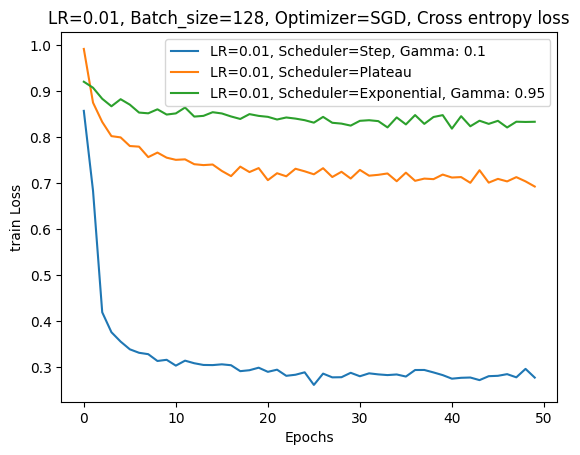

In [21]:
# Plot training loss
x = np.array(epochs_arr)
for i,train_loss in enumerate(losses_arr):
  ypoints = np.array(train_loss)
  plt.plot(x, ypoints, label = description[i])

plt.xlabel("Epochs")
plt.ylabel("train Loss")
plt.legend()
plt.title('LR=0.01, Batch_size=128, Optimizer=SGD, Cross entropy loss')
plt.show()

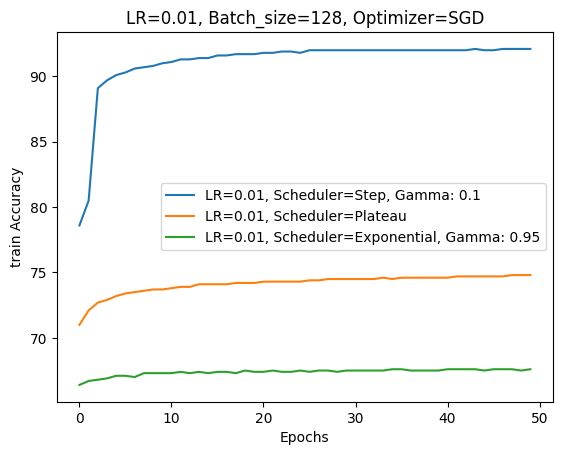

In [22]:
# Plot training accuracy
x = np.array(epochs_arr)
for i,train_acc in enumerate(train_accuracy_arr):
  ypoints = np.array(train_acc)
  plt.plot(x, ypoints, label = description[i])

plt.xlabel("Epochs")
plt.ylabel("train Accuracy")
plt.legend()
plt.title('LR=0.01, Batch_size=128, Optimizer=SGD')
plt.show()

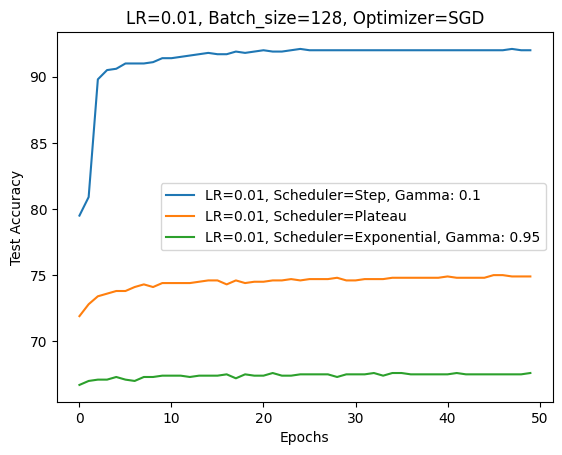

In [23]:
# Plot test accuracy
x = np.array(epochs_arr)
for i,test_acc in enumerate(test_accuracy_arr):
  ypoints = np.array(test_acc)
  plt.plot(x, ypoints, label = description[i])

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title('LR=0.01, Batch_size=128, Optimizer=SGD')
plt.show()

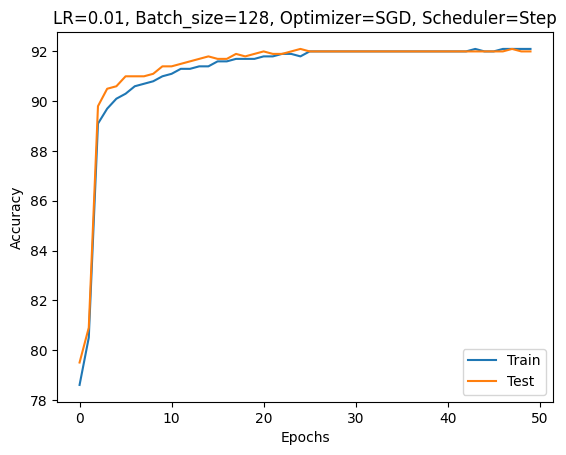

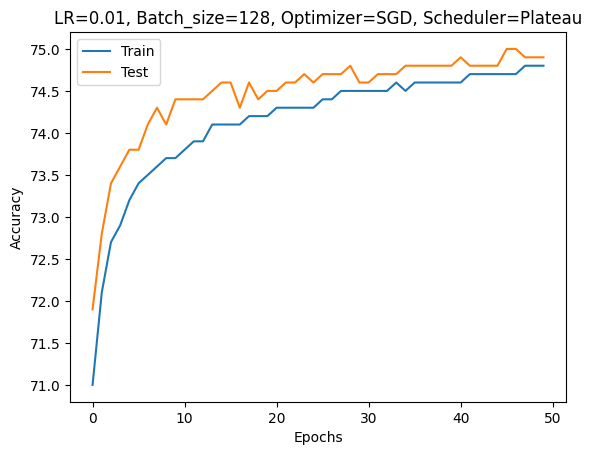

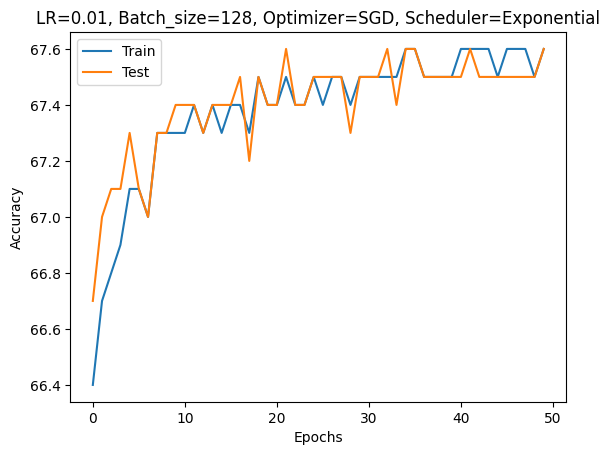

In [24]:
# Plot test and training accuracy
x = np.array(epochs_arr)
for i,lt in enumerate(LR_types):
  ypoints_1 = np.array(train_accuracy_arr[i])
  ypoints_2 = np.array(test_accuracy_arr[i])
  plt.plot(x, ypoints_1, label = 'Train')
  plt.plot(x, ypoints_2, label = 'Test')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title(F'LR=0.01, Batch_size=128, Optimizer=SGD, Scheduler={lt}')
  plt.show()

### Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
model_save_name = '1695168105559.8071_Step_bs128_e30_SGD_ss10_gamma0.1_mnist'
path = F"{model_save_name}.pt"
net.load_state_dict(t.load(path))

In [ ]:
test(net,test_loader)

In [ ]:
#hello kuch likhlo warna inactivity timeout de dega yeh